**Overview:**   
The GES DISC Application Program Interface (API) is a communication protocol allowing users to find the datasets and data granules they need, and download any desired subsets using scripts instead of the Web browser interface. Information is passed back and forth in JavaScript Object Notation (JSON) format.


**Example:**   
This example code demonstrates how to use the GES DISC API to retrieve Level 2 subsets of satellite data for the purpose of validation or comparison to ground-based measurements. The data product we'll be looking at is Total Column Ozone -- measured at the South Pole Observatory and compared to data from the TROPOMI instrument on board of the Copernicus Sentinel-5 Precursor (S5P) satellite ([S5P_L2__O3_TOT_1](https://disc.gsfc.nasa.gov/datasets/S5P_L2__O3_TOT_1/summary?keywords=S5P_L2__O3_TOT_1)).

ESRL web page where you can get Ozone data:
https://www.esrl.noaa.gov/gmd/dv/data/index.php?category=Ozone  
Link to file for South Pole Observations: 
ftp://aftp.cmdl.noaa.gov/data/ozwv/Dobson/dobson_toSPO.txt  
Link to sample file used in this Notebook: https://docserver.gesdisc.eosdis.nasa.gov/public/project/notebooks/dobson_toSPO_201811.txt

**Example Images:**  
<img src="https://disc.gsfc.nasa.gov/media/image/4cb4aedf114f496fb9f84ed5a9cbc92f/scatterplot.png" title="Image1"/>  

Figure 1: A scatter plot comparing daily ground-based and satellite-based measurements of total ozone in November 2018.  

<img src="https://disc.gsfc.nasa.gov/media/image/4bac8c25a25649029c5657637a7616db/timeseries.png" title="Image2"/>  

Figure 2: A time-series of daily ground-based and satellite-based measurements of total ozone in November 2018.  


**Prerequisites:**  
This example code is written in Python3 and requires these libraries: calendar, certifi, glob, h5py, json, matplotlib.pyplot, os, requests, subprocess, sys, time, urllib3.


**Procedure:**  
The initial step is to import the required Python libraries. If any of the following import commands fail, check the local Python environment and install any missing packages. 

In [6]:
import calendar
import certifi
import glob
import h5py
import json
import matplotlib.pyplot as plt
import os
import requests
import subprocess
import sys
import time
import urllib3

Initialize the _urllib_ Pool Manager, set the URL for all API service requests, and define three local methods for general-purpose tasks. The first method, <code>get_http_data</code>, submits JSON-formatted Web Services Protocol (WSP) requests to the GES DISC server and returns the service’s response. The other two methods, <code>get_statusRequest</code> and <code>get_resultRequest</code>, build the JSON requests to get the status and the results for a submitted job. 

In [7]:
# Set up the protocol to send API requests to the GES DISC server
http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED',ca_certs=certifi.where())
svcURL = 'https://disc.gsfc.nasa.gov/service/subset/jsonwsp'

# This method POSTs formatted JSON WSP requests to the GES DISC endpoint URL
def get_http_data(request):
    hdrs = {'Content-Type': 'application/json',
            'Accept'      : 'application/json'}
    data = json.dumps(request)       
    r = http.request('POST', svcURL, body=data, headers=hdrs)
    try:
        response = json.loads(r.data)   
        return response
    except:
        print('SOMETHING WENT WRONG!')
        print('Submitted request:\n',request)
        print('Returned response:\n',r.data)
        return({'result':{'Status':'Error'}})
    
# This method constructs a JSON WSP request for API method: GetStatus
def get_statusRequest(jid):
    statusRequest = {
        'methodname':'GetStatus',
        'type':'jsonwsp/request',
        'version':'1.0', 
        'args': {'jobId': jid}
    }
    return statusRequest

# This method constructs a JSON WSP request for API method: GetResult
def get_resultRequest(jid,batchsize):
    resultRequest = {
        'methodname': 'GetResult',
        'type': 'jsonwsp/request',
        'version': '1.0',
        'args': {'jobId': jid,
                 'count': batchsize,
                 'startIndex': 0}
    }
    return resultRequest

Define the static parameters for the satellite data subsets. These include the longitude and latitude of the ground-based observations, the name of the satellite data product, and the list of variables to extract. If the list of variable names is empty, then all the variables in the file will be downloaded.

In [8]:
# Ground-based observation location is at the South Pole Observatory
pointlon =  -24.8
pointlat = -89.99

# This is the satellite data product (Sentinel-5P TROPOMI Total Ozone Column) 
product = 'S5P_L2__O3_TOT_1'

# Desired variables for this example: the total ozone and the quality flag
# The Level 2 subsetter will automatically add geolocation variables for lat, lon, and time
varNames = ['/PRODUCT/ozone_total_vertical_column',
            '/PRODUCT/qa_value']

The next code block does the data collection. (Executing this code may take some time.) Our example has trimmed down the observations text file to only 30 records, and it took 15-20 seconds to process each record and download the subset files. Some diagnostic information is printed out to keep track of the data collection progress. The steps in the protocol are:
1. Open the text file containing all the relevant records for the ground-based observations, and initialize a list of subset filenames that will contain the validation data.
2. Loop over each record in the file, parsing the text to extract the observation date and time.
3. Use the calendar module to set the date/time values for the 12-hour window in which to search for coincident satellite estimates.
4. Construct an API subset request using the point location's latitude and longitude, the name of the satellite data product, the list of desired variables, and the beginning and ending times of the overlap window. To retrieve all the variables in the file, omit the 'variable': name pairs from the 'data' section of the subset request.
5. Submit the asynchronous subset request and monitor the job's progress.
6. When the job has finished successfully, submit an API request to retrieve the results: a list of granule URLs that contain data at the desired location within the 12-hour time window.
7. Loop over the list of URLs and get the timestamp for each data granule. Compare it to the observation time and choose the granule that has the smallest time difference.
8. Download the URL that will contain the desired granule subset – a single data value for each of the desired variables, the geolocation information, plus all the other metadata. Append the downloaded filename to the list of subsetFiles – we'll use this later to match each observation with a subset file.

In [9]:
# For this example, the observation file was trimmed to contain data only for November 2018
# Sample entry (with column headings):
# Local_Date  Time   DOY    UTC_Date    Time   DOY  Total_Ozone    Mu    INS   LS  Wavelength   Kind_of_Obs.
# 2018/11/01  22:11  305    2018/11/01  22:11  305     147.0     3.828   082   00    AD         Direct_Sun
# Link to sample file: https://docserver.gesdisc.eosdis.nasa.gov/public/project/notebooks/dobson_toSPO_201811.txt


obsfile = open('dobson_toSPO_201811.txt','r')
subsetFiles = []
for line in obsfile :

    # parse the observation UTC_Date components and convert into a calendar struct_time object
    words = line.split()
    obsTime = words[3]+' '+words[4]
    obsT = calendar.timegm(time.strptime(obsTime,"%Y/%m/%d %H:%M"))

    # set the endpoints of the granule search to be the observation time +/- 6 hours (21600 seconds)
    # create strings for beginning/end time in the syntax expected by the API
    begTime = time.strftime('%Y-%m-%dT%H:%M:%SZ',time.gmtime(obsT-21600))
    endTime = time.strftime('%Y-%m-%dT%H:%M:%SZ',time.gmtime(obsT+21600))

    # Construct JSON WSP request for the API method: subset
    subsetRequest = {
        'methodname':'subset',
        'type':'jsonwsp/request',
        'version':'1.0',
        'args': {
            'role'  : 'subset',
            'start' : begTime,
            'end'   : endTime,
            'lon'   : pointlon,
            'lat'   : pointlat,
            'crop'  : True,
            # Additional entries should be added here if VarNames list has more than two elements.
            'data' : [{'datasetId':product, 'variable':varNames[0]},
                      {'datasetId':product, 'variable':varNames[1]}]
            # Or use the following line instead to get all the variables in the file
            # 'data' : [{'datasetId':product}] 
        }
    }
   
    # Submit the subset request to the GES DISC Server.
    response = get_http_data(subsetRequest)

    # Report the JobID and initial status. Check to make sure the status is 'Accepted'. 
    myJobId = response['result']['jobId']
    print('\nObservation Time: %s' % obsTime)
    print('Job ID:',myJobId)
    print('Job Status:',response['result']['Status'])

    # Construct JSON WSP request for API method: GetStatus
    statusRequest = get_statusRequest(myJobId) 

    # Periodically check on the job status until it is no longer running
    while response['result']['Status'] in ['Accepted', 'Running']:
        time.sleep(3)
        response = get_http_data(statusRequest)
        status  = response['result']['Status']
        percent = response['result']['PercentCompleted']
        if percent < 100 : print('Job Status: %s (%d%c complete)' % (status,percent,'%'))

    if response['result']['Status'] == 'Succeeded' :
        print('Job Succeeded: %s' % response['result']['message'])
    else :
        print('Job Failed: %s',response)
        subsetFiles.append('missing')
        continue

    # Job succeeded; send JSON requests to retrieve the results in batches.
    batchsize = 20
    resultRequest = get_resultRequest(myJobId,batchsize)
    response = get_http_data(resultRequest) 
    total = response['result']['totalResults']
    if total == 0 : 
        print('Zero results found')
        subsetFiles.append('missing')
        continue

    # Build a list of the result items from the first batch.
    results = []
    count = response['result']['itemsPerPage']
    results.extend(response['result']['items']) 

    # Keep retrieving additional batches of results until we have them all.
    while count < total :
        # Increment the startIndex in the resultRequest 
        resultRequest['args']['startIndex'] += batchsize 
        response = get_http_data(resultRequest) 
        count = count + response['result']['itemsPerPage']
        results.extend(response['result']['items'])
        
    # Sort the results into documents and URLs
    docs = []
    urls = []
    for item in results :
        try:
            if item['start'] and item['end'] : urls.append(item) 
        except:
            docs.append(item)
             
    # Loop over the list of subset URLs returned by the API
    # Create corresponding lists of:
    #  the output file names (contents of the LABEL facet)
    #  the granule time
    #  the absolute value of the difference between granule time and observation time
    namelist = []
    grTlist = []
    dTlist = []
    for thisurl in urls :
        # extract the output filename ('label') and the date stamp 
        # example: S5P_OFFL_L2__O3_____20190809T113145_20190809T131315_09436_01_010107_20190815T135732.SUB.nc
        name = thisurl['label'][:]
        grTime = name[20:35]
        grTS = time.strptime(grTime,"%Y%m%dT%H%M%S")
        grT = calendar.timegm(grTS)
        namelist.append(name)
        grTlist.append(grT)
        dTlist.append(abs(grT-obsT))

    # Select the URL with the smallest difference between observed time and granule time 
    idx = dTlist.index(min(dTlist))
    subfn = namelist[idx]
    print('Subset File:',subfn)
    print('Time Difference:',str(grTlist[idx]-obsT),'seconds')

    # If we don't have it already, downloaded this subset URL, add the subset filename to the list
    if os.path.isfile(subfn):
        subsetFiles.append(subfn)
        print('Subset file already downloaded, adding to list')
    else: 
        result = requests.get(urls[idx]['link'])
        try:
            result.raise_for_status()
            f = open(subfn,'wb')
            f.write(result.content)
            f.close()
            subsetFiles.append(subfn)
            print('Subset file downloaded and added to list')
        except:
            subsetFiles.append('missing')
            print('Error! Status code is %d for this URL:\n%s' % (result.status.code,urls[idx]['link']))

# Close the obs data file 
obsfile.close()


Observation Time: 2018/11/01 22:11
Job ID: 647f89654a18c7cbff122660
Job Status: Accepted
Job Status: Accepted (0% complete)
Job Status: Accepted (0% complete)
Job Status: Accepted (0% complete)
Job Status: Accepted (0% complete)
Job Succeeded: Complete (S5P_L2__O3_TOT_1)
Subset File: S5P_RPRO_L2__O3_____20181101T224131_20181102T002459_05456_01_010107_20190518T200705.SUB.nc4
Time Difference: 1831 seconds
Subset file downloaded and added to list

Observation Time: 2018/11/02 21:53
Job ID: 647f898b227157cc7016c782
Job Status: Accepted
Job Status: Running (98% complete)
Job Succeeded: Complete (S5P_L2__O3_TOT_1)
Subset File: S5P_RPRO_L2__O3_____20181102T222223_20181103T000551_05470_01_010107_20190519T011447.SUB.nc4
Time Difference: 1763 seconds
Subset file downloaded and added to list

Observation Time: 2018/11/03 20:42
Job ID: 647f899a4d7c06cc8705c44f
Job Status: Accepted
Job Status: Running (98% complete)
Job Succeeded: Complete (S5P_L2__O3_TOT_1)
Subset File: S5P_RPRO_L2__O3_____201811

**Note:**  
The remaining code in this tutorial is designed to simply illustrate our example, and is unlikely to meet the needs of all users.  

Now the data collection is complete, and it is possible to compare the observations to the satellite estimates. Each of the subset files is opened and the data values in each satellite subset file are extracted, along with the corresponding observation from the original text file. Two lists are created, one containing the observed data values, the other containing the satellite estimates.

In [10]:
# Initialize lists of observed and satellite data values
obs = []
sat = []

# Reopen obs data file 
obsfile = open('dobson_toSPO_201811.txt','r')

# Loop over the observation records and the list of corresponding subset files
for line,subfn in zip(obsfile,subsetFiles) :
    if subfn == 'missing' : continue
    words = line.split()
    obsVal = float(words[6])

    # open the subset, extract the total ozone, the FillValue, and the quality flag
    fp = h5py.File(subfn,'r')
    o3 = fp ['/PRODUCT/ozone_total_vertical_column']
    qa = fp ['/PRODUCT/qa_value']
    o3Val = o3[:][0][0][0]*2241.15 # apply multiplication_factor_to_convert_to_DU 
    qaVal = qa[:][0][0][0]*0.01    # apply scale factor, values range from 0 (No Data) to 1 (Full Quality) 
    FV = o3.attrs.get("_FillValue")

    # if we have a valid high-quality satellite estimate, append data values to list
    if o3Val != FV and qaVal >= 0.5:     
        sat.append(o3Val)
        obs.append(obsVal)
        print("Using O3 value from",subfn)
        

Using O3 value from S5P_RPRO_L2__O3_____20181101T224131_20181102T002459_05456_01_010107_20190518T200705.SUB.nc4
Using O3 value from S5P_RPRO_L2__O3_____20181102T222223_20181103T000551_05470_01_010107_20190519T011447.SUB.nc4
Using O3 value from S5P_RPRO_L2__O3_____20181103T202146_20181103T220514_05483_01_010107_20190519T065618.SUB.nc4
Using O3 value from S5P_RPRO_L2__O3_____20181104T182109_20181104T200437_05496_01_010107_20190519T111449.SUB.nc4
Using O3 value from S5P_RPRO_L2__O3_____20181105T194331_20181105T212659_05511_01_010107_20190519T181738.SUB.nc4
Using O3 value from S5P_RPRO_L2__O3_____20181106T192424_20181106T210751_05525_01_010107_20190519T202411.SUB.nc4
Using O3 value from S5P_RPRO_L2__O3_____20181107T190516_20181107T204844_05539_01_010107_20190520T030220.SUB.nc4
Using O3 value from S5P_RPRO_L2__O3_____20181108T033244_20181108T051611_05544_01_010107_20190520T054412.SUB.nc4
Using O3 value from S5P_RPRO_L2__O3_____20181109T200832_20181109T215159_05568_01_010107_20190520T165534.

The following code blocks create a couple of simple plots that illustrate how the two different measurements compare. The first plot is a scatter diagram (shown above in Figure 1), and the second plot is a time-series (shown in Figure 2). 

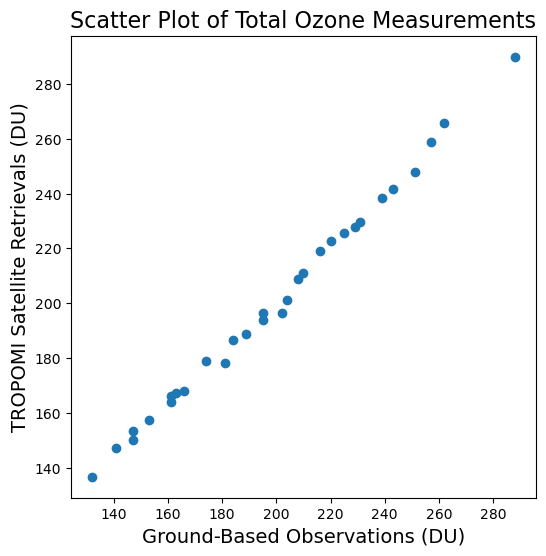

In [11]:
# This plot is a scatter diagram comparing each ground-based and satellite-based measurement.
plt.figure(figsize=(6,6))
p = plt.scatter(obs,sat)
t = plt.title('Scatter Plot of Total Ozone Measurements',fontsize=16)
x = plt.xlabel('Ground-Based Observations (DU)',fontsize=14)
y = plt.ylabel('TROPOMI Satellite Retrievals (DU)',fontsize=14)

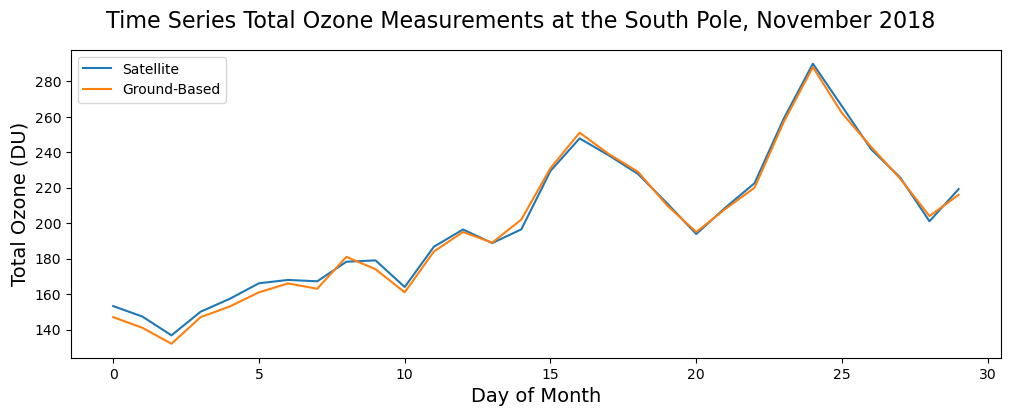

In [12]:
# This plot contains time series of ozone measurements from both sources for the month of November 2018
plt.figure(figsize=(12,4))
p1 = plt.plot(sat,label='Satellite')
p2 = plt.plot(obs,label='Ground-Based')
t = plt.suptitle('Time Series Total Ozone Measurements at the South Pole, November 2018',fontsize=16)
x = plt.xlabel('Day of Month',fontsize=14)
y = plt.ylabel('Total Ozone (DU)',fontsize=14)
l = plt.legend(loc='upper left', ncol=1)